### HW6. Stokes second problem
### 2022313047 Boyeon,Kim

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import linalg
import pandas as pd
from scipy.linalg import solve_banded

In [26]:
# Set plot params
plt.rcParams['figure.figsize'] = [5,5]
plt.rcParams['font.size'] = 10
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['xtick.major.size'] = 7
plt.rcParams['ytick.major.size'] = 7
plt.rcParams['xtick.minor.size'] = 3.5
plt.rcParams['ytick.minor.size'] = 3.5
plt.rcParams['xtick.major.width'] = 1.5
plt.rcParams['ytick.major.width'] = 1.5
plt.rcParams['xtick.minor.width'] = 1.5
plt.rcParams['ytick.minor.width'] = 1.5
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True

#### Consider an infinitely extended flat wall carrying out harmonic oscillation in its own plane (see Figure 1). Due to the no-slip condition, the flow velocity at the wall (where $y = 0$) is $u(0, t) = U_0 cos(nt)$.

#### 1. (Analytic solution)
(1) Starting from the three-dimensional Navier-Stokes equations, derive the simplified governing equation for the Stokes second problem. Provide all of the assumptions that are used in your derivation. 

eq.(1)  
$\frac{\partial u}{\partial t} = \nu \frac{\partial^2 u}{\partial y^2}$

#### (2) Show that the solution to the Stokes second problem is

eq.(2)  
$u(y, t) = U_0 e^{-{\eta}_s} cos(nt - \eta_s)$, where  $\eta_s = \sqrt{\frac{n}{2\nu}} y$

In [20]:
def exact_solution(n, nu, y, nt):
    etas = np.sqrt(n/(2*nu)) * y
    return np.cos(nt - etas) * np.exp(-etas)

In [39]:
# Given parameters
nu = 1
n = 2
U0 = 1
L = 10
T = 10*np.pi
nts = np.array([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi])

# Discretization parameters
dt = 0.001
N = 100                         # for y matrix
M = int(2*T/dt)                 # for t matrix
y = np.linspace(0, L, N)
t = np.linspace(0, 2*T, M)
dy = y[1] - y[0]


# Initialize u array with boundary conditions
u = np.zeros((M, N))            # u(t,y)
u[:, 0] = np.cos(n*t)           # lower boundary condition
u[:, -1] = 0                    # upper boundary condition

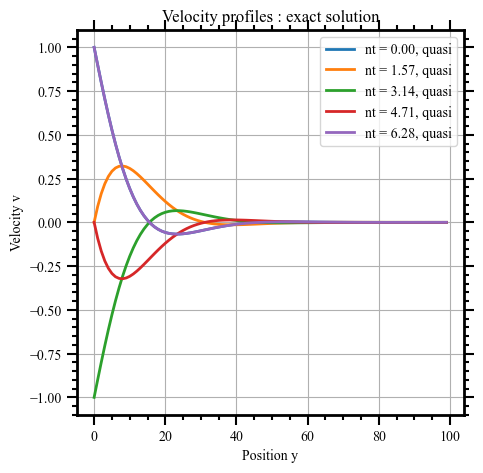

In [33]:
# plotting for exact
for nt in nts:
    exact_u = exact_solution(n, nu, y, nt)
    data3 = exact_u
    df3 = pd.DataFrame(data3)
    df3.to_csv(f'exact{nt:.0f}.csv')
    plt.plot(exact_u, label=f'nt = {nt:.2f}, quasi')
    plt.legend()
plt.xlabel('Position y')
plt.ylabel('Velocity v')
plt.title('Velocity profiles : exact solution')
plt.grid(True)
plt.show()

In [38]:
# Given parameters
nu = 1
n = 2
U0 = 1
L = 10
T = 10*np.pi
nts = np.array([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi])


# Discretization parameters
dt = 0.001
N = 100             # for y matrix
M = int(2*T/dt)     # for t matrix
y = np.linspace(0, L, N)
t = np.linspace(0, 2*T, M)
dy = y[1] - y[0]


# Initialize u array with boundary conditions
u = np.zeros((M, N))            # u(t,y)
u[:, 0] = np.cos(n*t)           # lower boundary condition
u[:, -1] = 0                    # upper boundary condition

# FTCS scheme
for i in range(M-1):
    for j in range(1, N-1):
        u[i+1, j] = u[i, j] + nu * (dt/dy**2) * (u[i, j+1] - 2*u[i, j] + u[i, j-1]) 



KeyboardInterrupt: 

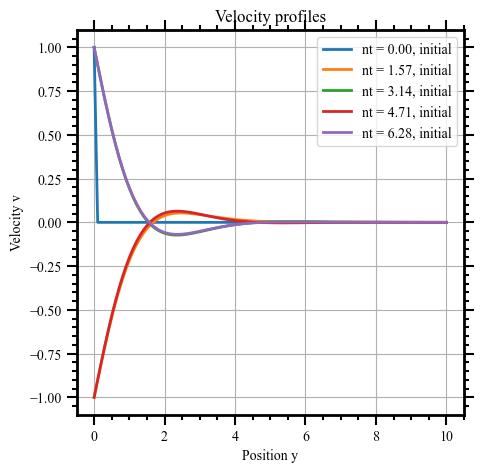

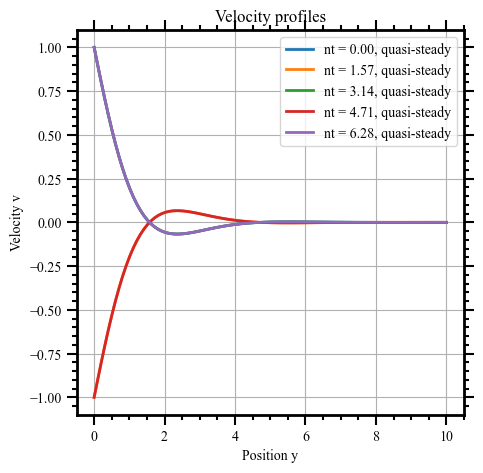

In [35]:
# Plotting for initial
for nt in nts:
    # for dataframe
    data2 = u[int(nt/dt), :]
    df2 = pd.DataFrame(data2)
    df2.to_csv(f'int{nt:.0f}.csv')
    plt.plot(y, u[int(nt/dt), :], label=f'nt = {nt:.2f}, initial')
plt.legend(loc = 'upper right')
plt.xlabel('Position y')
plt.ylabel('Velocity v')
plt.title('Velocity profiles')
plt.grid(True)
plt.show()

# Plotting for quasi-steady
for nt in nts:
    idx = int((nt+T) / dt)
    plt.plot(y, u[idx, :], label=f'nt = {nt:.2f}, quasi-steady')
    data1 = u[idx, :]
    df1 = pd.DataFrame(data1)
    df1.to_csv(f'qs{nt:.0f}.csv')
plt.legend(loc = 'upper right')
plt.xlabel('Position y')
plt.ylabel('Velocity v')
plt.title('Velocity profiles')
plt.grid(True)
plt.show()

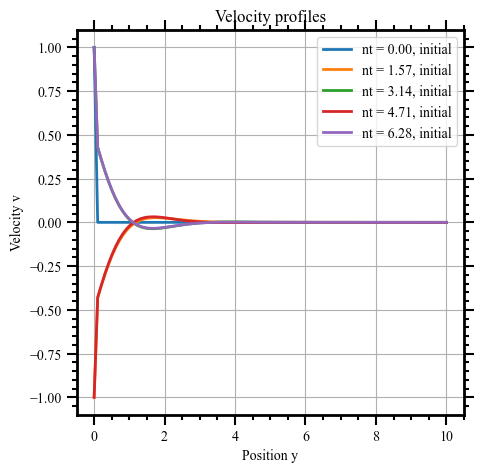

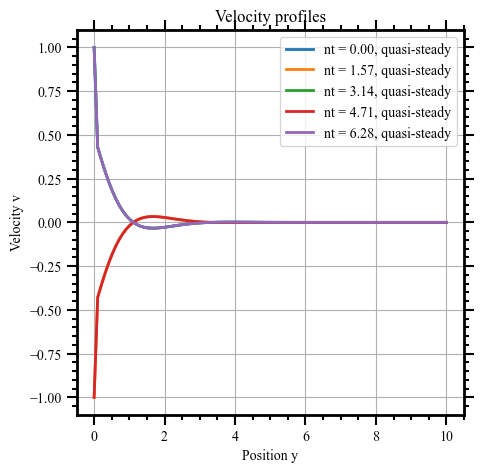

In [40]:
# Initialize u_cn array with boundary conditions
u_cn = np.zeros((M, N))            # u_cn(t,y)
u_cn[:, 0] = np.cos(n*t)           # lower boundary condition
u_cn[:, -1] = 0                    # upper boundary condition

# Crank-Nicolson scheme
for i in range(M-1):
    # Create A matrix for Crank-Nicolson
    A_upper = -nu*dt/(4*dy**2) * np.ones(N-2)
    A_mid = np.ones(N-2) + nu*dt/(2*dy**2)
    A_lower = -nu*dt/(4*dy**2) * np.ones(N-2)
    A = np.vstack((A_upper, A_mid, A_lower))
    
    # Create b vector for Crank-Nicolson
    b = u_cn[i, 1:-1] + nu*dt/(4*dy**2) * (u_cn[i, :-2] - 2*u_cn[i, 1:-1] + u_cn[i, 2:]) 
    
    # Solve Ax = b
    u_cn[i+1, 1:-1] = solve_banded((1, 1), A, b)

# Plotting
for nt in nts:
    plt.plot(y, u_cn[int(nt/dt), :], label=f'nt = {nt:.2f}, initial')
    plt.legend()
plt.xlabel('Position y')
plt.ylabel('Velocity v')
plt.title('Velocity profiles')
plt.grid(True)
plt.show()

# Plotting
for nt in nts:
    idx = int((nt+T) / dt)
    plt.plot(y, u_cn[idx, :], label=f'nt = {nt:.2f}, quasi-steady')
    plt.legend()
plt.xlabel('Position y')
plt.ylabel('Velocity v')
plt.title('Velocity profiles')
plt.grid(True)
plt.show()


In [42]:
# Given parameters
nu = 1
n = 2
U0 = 1
L = 2
T = 10*np.pi
nts = np.array([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi])


# Discretization parameters
dt = 0.001
N = 100             # for y matrix
M = int(2*T/dt)     # for t matrix
y = np.linspace(0, L, N)
t = np.linspace(0, 2*T, M)
dy = y[1] - y[0]


# Initialize u array with boundary conditions
u = np.zeros((M, N))            # u(t,y)
u[:, 0] = np.cos(n*t)           # lower boundary condition
u[:, -1] = 0                    # upper boundary condition

# FTCS scheme
for i in range(M-1):
    for j in range(1, N-1):
        u[i+1, j] = u[i, j] + nu * (dt/dy**2) * (u[i, j+1] - 2*u[i, j] + u[i, j-1]) 

/var/folders/d5/9q668tsd4bv5vpp3xf9y2_b40000gn/T/ipykernel_45707/3262537760.py:27: RuntimeWarning: overflow encountered in double_scalars
  u[i+1, j] = u[i, j] + nu * (dt/dy**2) * (u[i, j+1] - 2*u[i, j] + u[i, j-1])
/var/folders/d5/9q668tsd4bv5vpp3xf9y2_b40000gn/T/ipykernel_45707/3262537760.py:27: RuntimeWarning: invalid value encountered in double_scalars
  u[i+1, j] = u[i, j] + nu * (dt/dy**2) * (u[i, j+1] - 2*u[i, j] + u[i, j-1])


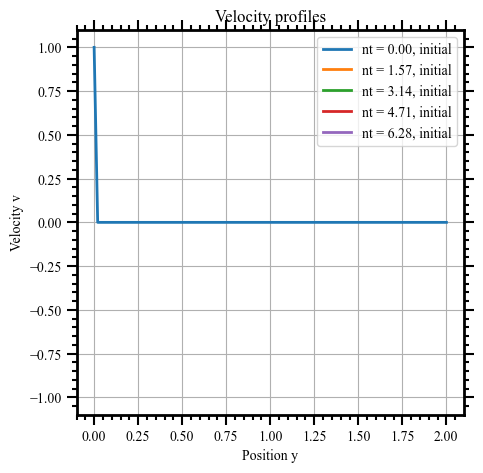

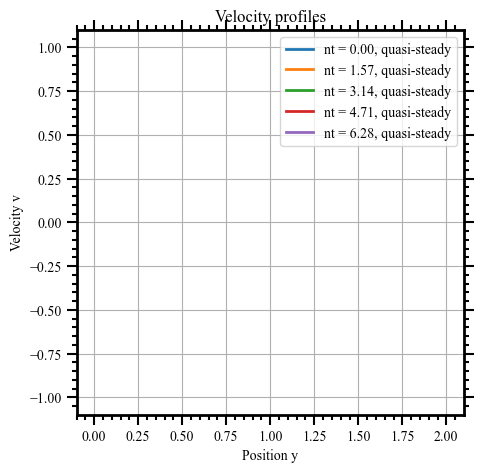

In [43]:
# Plotting for initial
for nt in nts:
    # for dataframe
    data2 = u[int(nt/dt), :]
    df2 = pd.DataFrame(data2)
    df2.to_csv(f'int{nt:.0f}.csv')
    plt.plot(y, u[int(nt/dt), :], label=f'nt = {nt:.2f}, initial')
plt.legend(loc = 'upper right')
plt.xlabel('Position y')
plt.ylabel('Velocity v')
plt.title('Velocity profiles')
plt.grid(True)
plt.show()

# Plotting for quasi-steady
for nt in nts:
    idx = int((nt+T) / dt)
    plt.plot(y, u[idx, :], label=f'nt = {nt:.2f}, quasi-steady')
    data1 = u[idx, :]
    df1 = pd.DataFrame(data1)
    df1.to_csv(f'qs{nt:.0f}.csv')
plt.legend(loc = 'upper right')
plt.xlabel('Position y')
plt.ylabel('Velocity v')
plt.title('Velocity profiles')
plt.grid(True)
plt.show()